In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import networkx as nx
from pprint import pprint
import os
import json

## Dataset from Kaggle: https://www.kaggle.com/rounakbanik/the-movies-dataset

In [2]:
# Read the files
movies_metadata = pd.read_csv('movies_metadata.csv')

/Users/zipengliu/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Remove rows with dirty data
shitty_idx = []
for idx, row in movies_metadata.iterrows():
    if not row['id'].isdigit():
        shitty_idx.append(idx)
print(shitty_idx)
movies_metadata.drop(shitty_idx, axis=0, inplace=True)

[19730, 29503, 35587]


In [4]:
# Read the mapping between different id systems
links_df = pd.read_csv('links.csv')
links_df.set_index('tmdbId', inplace=True)
links_df.loc[27205]

movieId      79132
imdbId     1375666
Name: 27205.0, dtype: int64

In [5]:
# Change the index type to int and remove duplicated
print(movies_metadata.shape)
movies_metadata['id'] = movies_metadata['id'].astype('int64')
movies_metadata.drop_duplicates(subset='id', inplace=True)
movies_metadata.rename(columns={'id': 'tmdbId'}, inplace=True)
movies_metadata.set_index('tmdbId', inplace=True)
print(movies_metadata.shape)
print(movies_metadata.index)

(45463, 24)
(45433, 23)
Int64Index([   862,   8844,  15602,  31357,  11862,    949,  11860,  45325,
              9091,    710,
            ...
             84419, 390959, 289923, 222848,  30840, 439050, 111109,  67758,
            227506, 461257],
           dtype='int64', name='tmdbId', length=45433)


In [6]:
keywords = pd.read_csv('keywords.csv')
print(keywords.shape)
keywords.drop_duplicates(subset='id', inplace=True)
keywords.set_index('id', inplace=True)
print(keywords.shape)

(46419, 2)
(45432, 1)


In [7]:
credits = pd.read_csv('credits.csv')
print(credits.shape)
credits.drop_duplicates(subset='id', inplace=True)
credits.set_index('id', inplace=True)
print(credits.shape)

(45476, 3)
(45432, 2)


In [8]:
df = movies_metadata.join(keywords, how='inner').join(credits, how='inner')

In [9]:
print(movies_metadata.shape)
print(keywords.shape)
print(credits.shape)
print(df.shape)

(45433, 23)
(45432, 1)
(45432, 2)
(45432, 26)


In [10]:
df.head()

,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords,cast,crew
862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
8844,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
31357,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
11862,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [11]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'keywords', 'cast', 'crew'],
      dtype='object')

In [12]:
# Clean and transform some columns that comes with an array
parse_col = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages', 
             'cast', 'crew', 'belongs_to_collection']
for column in parse_col:
    df[column] = df[column].fillna('[]').apply(literal_eval)
    df[column + '_cnt'] = df[column].map(len)
    print(column)
    print(df[column + '_cnt'].describe())
    print()

genres
count    45432.000000
mean         2.003324
std          1.130698
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: genres_cnt, dtype: float64

keywords
count    45432.000000
mean         3.446954
std          4.690083
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        149.000000
Name: keywords_cnt, dtype: float64

production_countries
count    45432.000000
mean         1.086635
std          0.763007
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         25.000000
Name: production_countries_cnt, dtype: float64

production_companies
count    45432.000000
mean         1.550977
std          1.741638
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         26.000000
Name: production_companies_cnt, dtype: float64

spoken_languages
count    45432.000000
mean         1.172434
std        

In [13]:
# A hack to get rid of the NaN, which is not compatible with JSON serializer
df['homepage'].fillna('', inplace=True)
df['tagline'].fillna('', inplace=True)

In [14]:
# Take a look at the "array-like" columns by constructing different tables from them
def inspect_entities(e_name, id_col='id', include_cols=[]):
    entity_dict = {}
    for idx, row in df.iterrows():
        # quick hack for columns that are of type dict instead of array of dict
        temp = [row[e_name]] if e_name == 'belongs_to_collection' and pd.notna(row[e_name]) else row[e_name]
        for g in temp:
            eid = g[id_col]
            if eid not in entity_dict:
                entity_dict[eid] = {'name': g['name'], 'count': 0}
                # fill in the fields to be included
                for f in include_cols:
                    if f in g:
                        entity_dict[eid][f] = g[f]
            entity_dict[eid]['count'] += 1
    entity_df = pd.DataFrame(entity_dict).transpose()
    entity_df['count'] = entity_df['count'].astype('int')
    entity_df.sort_values('count', ascending=False, inplace=True)
    return entity_df

In [15]:
genres_df = inspect_entities('genres')
genres_df

,name,count
18,Drama,20244
35,Comedy,13176
53,Thriller,7619
10749,Romance,6730
28,Action,6592
27,Horror,4671
80,Crime,4304
99,Documentary,3930
12,Adventure,3490
878,Science Fiction,3044


In [16]:
# plt.hist(genres_df['count'], bins=50)
# plt.grid(True)
# plt.show()

In [17]:
keywords_df = inspect_entities('keywords')
keywords_df

,name,count
187056,woman director,3039
10183,independent film,1914
9826,murder,1285
818,based on novel,822
4344,musical,726
...,...,...
188607,rube,1
188606,middle america,1
166244,beatboxing,1
208126,crown jewels,1


<IPython.core.display.Javascript object>


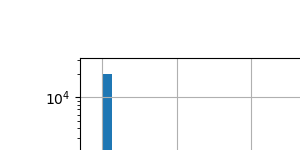

In [18]:
plt.hist(keywords_df['count'], bins=50, log=True)
plt.grid(True)
plt.show()

In [19]:
cast_df = inspect_entities('cast', include_cols=['gender', 'profile_path'])
cast_df

,name,count,gender,profile_path
121323,Bess Flowers,241,1,/akbW8jJl8GSXFpixFaobMOqvNv4.jpg
113,Christopher Lee,148,2,/aVzp6zflzedmdKPLxaPqcZ05PDK.jpg
4165,John Wayne,125,2,/iw9gHSQj1l3TQeiJb5tNK2N8k2w.jpg
2231,Samuel L. Jackson,123,2,/AvCReLikjzYEf9XjTQxbv3JWgKT.jpg
3895,Michael Caine,110,2,/vvj0JMSFpOajXCE46Hy4dyqSP2U.jpg
...,...,...,...,...
587632,Kim Mi-Kyung,1,1,/bRLtZnO0epZSMkTvOYyi6I4woDH.jpg
587641,Sa-Hee,1,0,/4yQTMDd1ltqiUDCC5jqaHpu5INk.jpg
186018,Jack Elliott,1,0,None
1179594,Odetta,1,0,None


In [20]:
# Note: assume the same person will be in the same department and the same job for simplicity (which is NOT true) 
crew_df = inspect_entities('crew', include_cols=['gender', 'department', 'job', 'profile_path'])
crew_df

,name,count,gender,department,job,profile_path
9062,Cedric Gibbons,272,2,Art,Art Direction,/w8tc9iVH87Iu1KKFDZ9B99NhnBc.jpg
2952,Avy Kaufman,184,1,Production,Casting,/yQPGktsmkKkhkOQAUlmYlxHJOiJ.jpg
4350,Edith Head,165,1,Costume & Make-Up,Costume Design,/63ZeXQOh26sGa8nTbYWntieyWrz.jpg
102429,Roger Corman,155,2,Production,Executive Producer,/gCfEvxl7jTv2dBo8HvwWVMi3auz.jpg
1259,Ennio Morricone,153,2,Sound,Music,/tlntfyflyEHgJTFjqIgg8P8UIx9.jpg
...,...,...,...,...,...,...
1782549,Vail Romeyn,1,1,Production,Production Supervisor,None
1782548,Justin Haut,1,0,Production,Production Coordinator,None
1782545,Adam Boor,1,0,Art,Location Scout,None
1782543,Jamie Stires,1,0,Production,Casting Associate,None


In [21]:
prod_comp_df = inspect_entities('production_companies')
prod_comp_df

,name,count
6194,Warner Bros.,1250
8411,Metro-Goldwyn-Mayer (MGM),1074
4,Paramount Pictures,1001
306,Twentieth Century Fox Film Corporation,836
33,Universal Pictures,830
...,...,...
26338,Atrium Productions,1
21332,Eye Entertainment,1
64891,Ombadsman,1
618,Deutsche Filmvertriebs GmbH,1


In [22]:
prod_countries_df = inspect_entities('production_countries', id_col='iso_3166_1')
prod_countries_df

,name,count
US,United States of America,21140
GB,United Kingdom,4091
FR,France,3932
DE,Germany,2249
IT,Italy,2166
...,...,...
MG,Madagascar,1
SO,Somalia,1
KW,Kuwait,1
MQ,Martinique,1


In [23]:
lang_df = inspect_entities('spoken_languages', id_col='iso_639_1')
lang_df

,name,count
en,English,28727
fr,Français,4193
de,Deutsch,2624
es,Español,2413
it,Italiano,2366
...,...,...
ht,,1
to,,1
ty,,1
kw,,1


In [24]:
collections_df = inspect_entities('belongs_to_collection', include_cols=['poster_path', 'backdrop_path'])
collections_df

/Users/zipengliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


,name,count,poster_path,backdrop_path
415931,The Bowery Boys,29,/q6sA4bzMT9cK7EEmXYwt7PNrL5h.jpg,/foe3kuiJmg5AklhtD3skWbaTMf2.jpg
421566,Totò Collection,27,/4ayJsjC3djGwU9eCWUokdBWvdLC.jpg,/jaUuprubvAxXLAY5hUfrNjxccUh.jpg
645,James Bond Collection,26,/HORpg5CSkmeQlAolx3bKMrKgfi.jpg,/6VcVl48kNKvdXOZfJPdarlUGOsk.jpg
96887,Zatôichi: The Blind Swordsman,26,/8Q31DAtmFJjhFTwQGXghBUCgWK2.jpg,/bY8gLImMR5Pr9PaG3ZpobfaAQ8N.jpg
37261,The Carry On Collection,25,/2P0HNrYgKDvirV8RCdT1rBSJdbJ.jpg,/38tF1LJN7ULeZAuAfP7beaPMfcl.jpg
...,...,...,...,...
147207,Glass Tiger collection,1,/f8h1V44zKFOFuW4DF56oV5ENu5r.jpg,/ehLhVlA5riW7xYTmefb7Hqf0hMd.jpg
260520,Kathleen Madigan Collection,1,None,None
268014,The Big Bottom Box,1,/5i9awYAZqAAleGx8JFTVZILnXMx.jpg,None
479549,Joséphine - Saga,1,/yxp6kDbIAbDzyoUkAONISnc2Zfj.jpg,/29ETFnPUNcsH9r7MflZ3Op0APJi.jpg


In [25]:
df.to_csv('combined_dataframe.csv')

In [26]:
ratings_df = pd.read_csv('ratings.csv')

In [27]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [28]:
ratings_df.set_index('movieId', drop=False, append=True, inplace=True)

In [29]:
ratings_df[ratings_df['movieId'] == 79132]

,,userId,movieId,rating,timestamp
,movieId,,,,
189,79132,7,79132,3.0,1486253597
1112,79132,15,79132,2.0,1346008186
1269,79132,16,79132,4.0,1485645845
1560,79132,20,79132,3.5,1367493805
2486,79132,28,79132,4.5,1392410262
...,...,...,...,...,...
26019885,79132,270871,79132,3.5,1394316894
26020839,79132,270884,79132,4.5,1498251799
26021000,79132,270886,79132,3.0,1462313230


In [30]:
# Compute some attributes for users
user_groups = ratings_df.groupby('userId')

In [31]:
user_rating_counts = user_groups['rating'].count()
user_rating_mean = user_groups['rating'].mean()

In [32]:
user_rating_counts

userId
1          27
2          22
3          10
4          62
5          26
         ... 
270892     75
270893    190
270894    148
270895     20
270896    260
Name: rating, Length: 270896, dtype: int64

## Sample and construct graphs

In [33]:
movie_cols = ['adult', 'budget', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies_cnt',
       'production_countries_cnt', 'release_date', 'revenue', 'runtime',
       'spoken_languages_cnt', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'keywords_cnt', 'cast_cnt', 'crew_cnt']

# For types such as crew, cast, production companies, keywords, genres
other_type_cols = ['count', 'gender', 'department', 'job', 'poster_path', 'backdrop_path']

In [34]:
other_type_df = {
    'genres': genres_df,
    'keywords': keywords_df,
    'production_companies': prod_comp_df,
    'production_countries': prod_countries_df,
    'cast': cast_df,
    'crew': crew_df,
    'spoken_languages': lang_df,
    'belongs_to_collection': collections_df
}

In [35]:
# Get a dict of the attributes of a node (pandas.Series)
def get_node_attributes(node, fields):
    a = node.to_dict()
    ret = {}
    for f in fields:
        if f in a:
            ret[f] = int(a[f]) if f is 'count' else a[f]
    return ret

In [36]:
def create_nodes_and_edges(df, output_dir, include_node_types, limits, with_ratings=None):
    # Write the dataframe to disk for backup
    if not os.path.exists(output_dir):
        print('Create directory: ', output_dir)
        os.makedirs(output_dir)
    top_voted.to_csv(os.path.join(output_dir, 'dataframe.csv'))
    
    # Mapping from original id in the data table to the index in the nodes array
    # We need to use a new index system because the original ids are separated for different entities
    movie_mapping = {}
    other_type_mapping = []
    for i in range(len(include_node_types)):
        other_type_mapping.append({})
    if with_ratings:
        other_type_mapping.append({})
        
#     edges = []
#     nodes = []
    g = nx.Graph()
    node_idx = 0
    edge_idx = 0
    
    for tmdb_id, m in top_voted.iterrows():
        movie_id = links_df.loc[tmdb_id]['movieId']
        # print('Processing movie ', movie_id, m['title'])
#         nodes.append({'original_id': movie_id, 'label': m['original_title'], 'type': 'movie'})
        g.add_node(node_idx, original_id=int(movie_id), label=m['original_title'], type='movie', 
                   **get_node_attributes(m, movie_cols))
        movie_mapping[movie_id] = node_idx
        node_idx += 1

        for type_idx, t in enumerate(include_node_types):
            # assuming it is an array 
            column_array = m[t][:limits[type_idx]] if limits[type_idx] > 0 else m[t]
            for c in column_array:
                if c['id'] not in other_type_mapping[type_idx]:
#                     nodes.append({'original_id': c['id'], 'label': c['name'], 'type': t})
                    # print(get_node_attributes(other_type_df[t].loc[c['id']], other_type_cols))
                    g.add_node(node_idx, original_id=c['id'], label=c['name'], type=t,
                              **get_node_attributes(other_type_df[t].loc[c['id']], other_type_cols))
                    other_type_mapping[type_idx][c['id']] = node_idx
                    node_idx += 1
#                 edges.append({
#                     'source': movie_mapping[movie_id], 
#                     'target': other_type_mapping[type_idx][c['id']], 
#                     'weight': 1.0
#                 })
                g.add_edge(movie_mapping[movie_id], other_type_mapping[type_idx][c['id']])
                
        if with_ratings:
            for rid, r in ratings_df[ratings_df['movieId'] == movie_id].iloc[:with_ratings].iterrows():
                if r['userId'] not in other_type_mapping[-1]:
#                     nodes.append({'original_id': int(r['userId']), 'label': r['userId'], 'type': 'user'})
                    uid = int(r['userId'])
                    g.add_node(node_idx, original_id=uid, label=uid, type='user', avr=float(user_rating_mean[uid]), cnt=int(user_rating_counts[uid]))
                    other_type_mapping[-1][r['userId']] = node_idx
                    node_idx += 1
#                 edges.append({
#                     'source': movie_mapping[movie_id], 
#                     'target': other_type_mapping[-1][r['userId']], 
#                     'weight': r['rating']
#                 })
                g.add_edge(movie_mapping[movie_id], other_type_mapping[-1][r['userId']], weight=r['rating'])
                # print(g.number_of_edges(), other_type_mapping[-1][r['userId']], g.degree[other_type_mapping[-1][r['userId']]])


#     print(len(nodes), len(edges))
    print('# nodes: ', g.number_of_nodes(), '\t # edges: ', g.number_of_edges())
    # Construct dataframes to emit
#     nodes_df = pd.DataFrame(nodes)
#     edges_df = pd.DataFrame(edges)
#     nodes_df.to_csv(os.path.join(output_dir, 'nodes.csv'), index_label='node_index')
#     edges_df.to_csv(os.path.join(output_dir, 'edges.csv'), index_label='edge_index')
        
    json_data = nx.node_link_data(g)
    json.dump(json_data, open(os.path.join(output_dir, 'graph.json'), 'w'), indent=2, allow_nan=False)
    return g

### 1. small graph with 10 top voted movies, and top 5 cast, and top 5 production companies (3 node types)

In [38]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:10]
g = create_nodes_and_edges(top_voted, './graphs/small-10-movies/', ['cast', 'production_companies'], [5, 5])

# nodes:  84 	 # edges:  87


### 2. medium-sized graph with 20 top voted movies, and top 5 cast,  top 3 production companies, genres, and keywords (5 node types)

In [39]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:20]
g = create_nodes_and_edges(top_voted, './graphs/medium-20-movies/', 
                                            ['cast', 'production_companies', 'genres', 'keywords'], [5, 5, -1, -1])

# nodes:  404 	 # edges:  536


### 3. medium-sized graph with 20 top voted movies, and top 5 cast,  top 3 production companies, genres, and 20 user ratings (5 node types)

In [40]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:20]
g = create_nodes_and_edges(top_voted, './graphs/medium-20-movies-with-ratings/', 
                                            ['cast', 'production_companies', 'genres'], [5, 5, -1], 20)

# nodes:  281 	 # edges:  629


### 4. large graph with 100 top voted movies, and top 10 cast,  top 3 production companies, genres, and 30 user ratings (5 node types)

In [41]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:100]
g = create_nodes_and_edges(top_voted, './graphs/large-100-movies-with-ratings/', 
                                            ['cast', 'production_companies', 'genres'], [10, 5, -1], 30)

# nodes:  1388 	 # edges:  4629


### 5. large graph with 500 top voted movies, and top 15 cast, top 4 production companies, genres, and 50 user ratings (5 node types)

In [42]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:500]
g = create_nodes_and_edges(top_voted, './graphs/large-500-movies-with-ratings/', 
                                            ['cast', 'production_companies', 'genres'], [20, 5, -1], 50)

# nodes:  9345 	 # edges:  37851


### 6. medium-sized bipartite graph with 20 top voted movies, and 40 user ratings per movie

In [43]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:20]
g = create_nodes_and_edges(top_voted, './graphs/bipartite-user-movie-medium-1/', [], [], 40)

# nodes:  259 	 # edges:  800


### 7. medium-sized bipartite graph with 40 top voted movies, and 80 user ratings per movie

In [38]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:50]
g = create_nodes_and_edges(top_voted, './graphs/bipartite-user-movie-medium-3/', [], [], 100)

Create directory:  ./graphs/bipartite-user-movie-medium-3/
# nodes:  1088 	 # edges:  5000


### 8. large-sized bipartite graph with 100 top voted movies, and 500 user ratings per movie

In [45]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:100]
g = create_nodes_and_edges(top_voted, './graphs/bipartite-user-movie-large-1/', [], [], 500)

# nodes:  7407 	 # edges:  50000


### 9. large-sized bipartite graph with 200 top voted movies, and 1000 user ratings per movie

In [46]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:200]
g = create_nodes_and_edges(top_voted, './graphs/bipartite-user-movie-large-2/', [], [], 1000)

# nodes:  20619 	 # edges:  198250


### 10. medium-sized tripartite graph with 20 top voted movies, and 40 user ratings per movie, and the production companies

In [47]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:20]
g = create_nodes_and_edges(top_voted, './graphs/tripartite-user-movie-prodComp-medium-1/', ['production_companies'], [5], 40)

# nodes:  303 	 # edges:  868


### 11. large-sized tripartite graph with 100 top voted movies, and 500 user ratings per movie, and the production companies

In [48]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:100]
g = create_nodes_and_edges(top_voted, './graphs/tripartite-user-movie-prodComp-large-1/', ['production_companies'], [5], 500)

# nodes:  7548 	 # edges:  50321


### 12. medium-sized tripartite graph with 20 top voted movies, and 40 user ratings per movie, and the genres

In [49]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:20]
g = create_nodes_and_edges(top_voted, './graphs/tripartite-user-movie-genre-medium-1/', ['genres'], [-1], 40)

# nodes:  269 	 # edges:  861


### 13. large-sized tripartite graph with 20 top voted movies, and 40 user ratings per movie, and the genres

In [50]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:100]
g = create_nodes_and_edges(top_voted, './graphs/tripartite-user-movie-genre-large-1/', ['genres'], [-1], 500)

# nodes:  7423 	 # edges:  50311
